In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 250)
pd.set_option('max_colwidth', 100)

In [2]:
data = pd.read_parquet("photos.parquet")

In [3]:
data.head(2)

,file,filename,directory,brand,model,created,exposure,fnumber,focallength,focallength_35mm,iso,exp_compensation,lens,shutter_count,mechanical_shutter_count,flash,af,quality
0,"/home/andrei/Pictures/Photo/2004/200406_Фотоохота, Ватутинки/2004.06-2004.10-00560-022.jpg",2004.06-2004.10-00560-022.jpg,"/home/andrei/Pictures/Photo/2004/200406_Фотоохота, Ватутинки",None,None,NaT,0.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None
1,"/home/andrei/Pictures/Photo/2004/200406_Фотоохота, Ватутинки/2004.06-2004.10-00560-002.jpg",2004.06-2004.10-00560-002.jpg,"/home/andrei/Pictures/Photo/2004/200406_Фотоохота, Ватутинки",None,None,NaT,0.0,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,None,None


## Some stats on raw data

In [4]:
data[data["brand"] == "SONY"][["model", "directory"]].drop_duplicates()

,model,directory
8762,ILCE-7RM3,/home/andrei/Pictures/Photo/2020/202002_Лена_Прогулка_Встреча
12748,ILCE-6300,/home/andrei/Pictures/Photo/2019/201911_Лена_LittleDrama
14843,ILCE-7C,/home/andrei/Pictures/Photo/2023/202308_Венчание
21026,DSC-TX9,/home/andrei/Pictures/Photo/2011/20110903_Мама_Встреча одноклассников/1
23235,ILCE-9M2,/home/andrei/Pictures/Photo/2022/202206_Aha22


## Deduplicate

Remove duplicate records for RAW + JPEG pairs

In [5]:
data_clear = (
    data
    .groupby(["brand", "model", "created"])
    .agg({
        "shutter_count": "max", 
        "mechanical_shutter_count": "max", 
        "lens": "max",
        "file": list, 
        "exposure": "max", 
        "fnumber": "max",
        "focallength": "max",
        "focallength_35mm": "max",
        "iso": "max",
        "exp_compensation": "max",
        "flash": "max",
        "af": "max",
        "quality": list,
    })
    .reset_index()
)

In [6]:
len(data_clear)

20770

In [7]:
data_clear.groupby(["brand", "model"])["file"].count().reset_index()

,brand,model,file
0,Apple,iPhone 12 Pro,551
1,Apple,iPhone 5,692
2,Apple,iPhone 6,11
3,Apple,iPhone 7,498
4,BQru,BQ-5000G,36
5,Canon,Canon DIGITAL IXUS 60,29
6,Canon,Canon EOS 200D,23
7,Canon,Canon EOS 40D,28
8,Canon,Canon EOS 50D,137
9,Canon,Canon EOS 5D Mark II,9


## Filter photos by cameras and date

In [8]:
photos = (
    data_clear[
        data_clear['model'].isin(['NIKON D70s', 'NIKON D700', 'NIKON D780'])
        # & (data_clear['created'] >= '2022-09-30 00:00:00') & (data_clear['created'] <= '2022-10-30 00:00:00')
    ]
    .sort_values(by='created')
    .reset_index(drop=True)
    .copy()
)

## Maintain some lists

In [9]:
cameras = photos["model"].unique()

In [10]:
lens = photos["lens"].unique()

In [11]:
lensmap = {
    ' 50mm f/1.8D': '50 Any',
    '50 50 1.8 1.8 2': '50 Any',
    ' 50mm f/1.4G': '50 Any',
    
    'VR 24-70mm f/2.8E': '24-70 Any',
    ' 28-70mm f/2.8D': '24-70 Any', 
    '28 70 2.8 2.8 2': '24-70 Any', 
    '28.0-70.0 mm f/2.8': '24-70 Any',
    
    '70 300 4 5.6 6': '70-300 Any', 
    'VR 70-300mm f/4.5-5.6E': '70-300 Any',
    
    'VR 16-35mm f/4G': '16-35 Any',
    '20 35 3.5 4.5 2': '16-35 Any',
    ' 20-35mm f/3.5-4.5D': '16-35 Any',
    
    '18 70 3.5 4.5 6': '18-70', 
    
    None: 'unknown',
    "None": "unknown",
    '0 0 0 0 1': 'unknown', 
    ' ': 'unknown', 
}


photos["lens_mapped"] = photos['lens'].map(lensmap)
lens_mapped = photos["lens_mapped"].unique()

## Add extra columns

In [12]:
photos["ev"] = photos.apply(
    lambda x: math.log(
        x["fnumber"]**2 * x["exposure"] * 100 / x["iso"] / 2**x["exp_compensation"] + 1e-5, 
        2
    ), 
    axis=1
)

In [13]:
for camera in cameras:
    photos[camera] = None
    photos[camera] = photos.apply(lambda x: x['shutter_count'] if x['model'] == camera else None, axis=1)
    photos[camera] = photos[camera].fillna(method="ffill").fillna(0)

photos['total_releases'] = photos.apply(lambda x: x[cameras].sum(), axis=1)
photos['total_releases'] -= photos['total_releases'].min()

### Shutter releases by date

In [14]:
def plot_total_releases(df, group=None):
    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(df['created'], df['total_releases'], label="total")
    
    if group:
        if isinstance(group, str):
            grouped = df[[group, 'created', 'shutter_count']].groupby(group)
        else:
            grouped = df[[*group, 'created', 'shutter_count']].groupby(group)
        for grp_id, group in grouped:
            group["shutter_count"] -= group["shutter_count"].min()
            ax.plot(group['created'], group['shutter_count'], label=grp_id)
    ax.legend()
    plt.xlabel('Date')
    plt.ylabel('Shutter releases')
    plt.grid()
    plt.show()

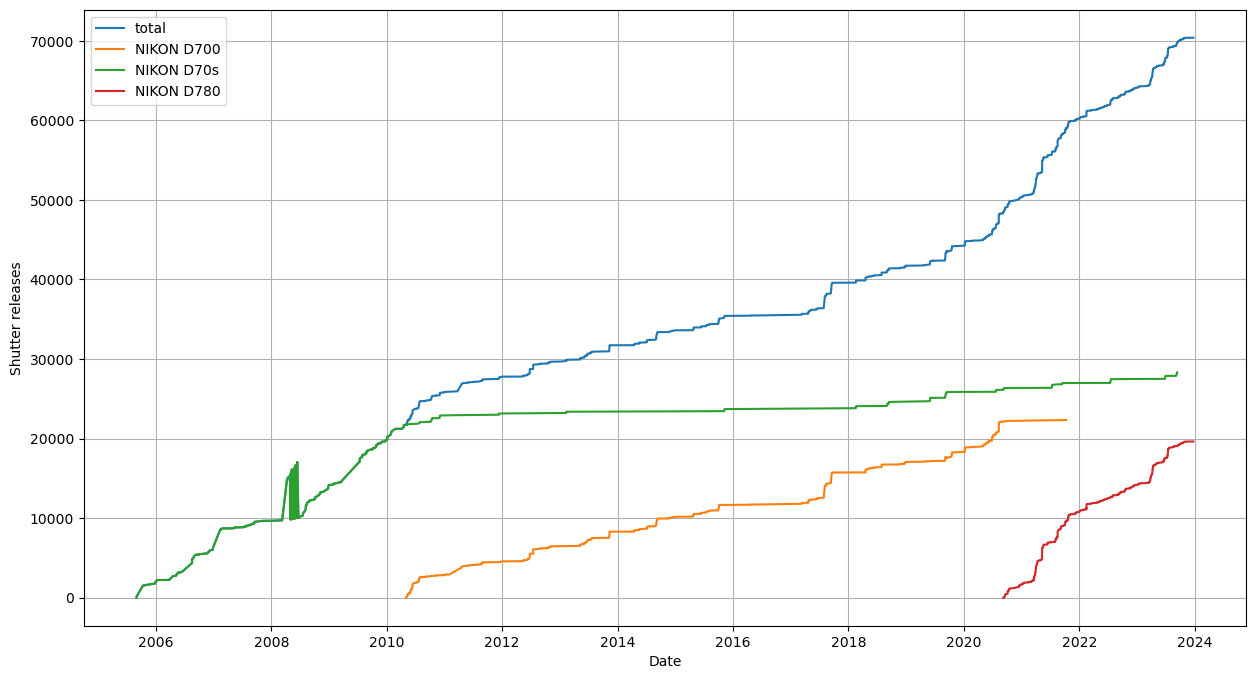

In [15]:
plot_total_releases(photos, "model")

In [16]:
def plot_successful_releases(df, group=None):
    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(df['created'], df.reset_index(drop=True).reset_index()["index"], label="total")
    
    if group:
        if isinstance(group, str):
            grouped = df[[group, 'created', 'shutter_count']].groupby(group)
        else:
            grouped = df[[*group, 'created', 'shutter_count']].groupby(group)
        for grp_id, group in grouped:
            ax.plot(group['created'], group.reset_index(drop=True).reset_index()["index"], label=grp_id)
    ax.legend()
    plt.xlabel('Date')
    plt.ylabel('Shutter releases')
    plt.grid()
    plt.show()

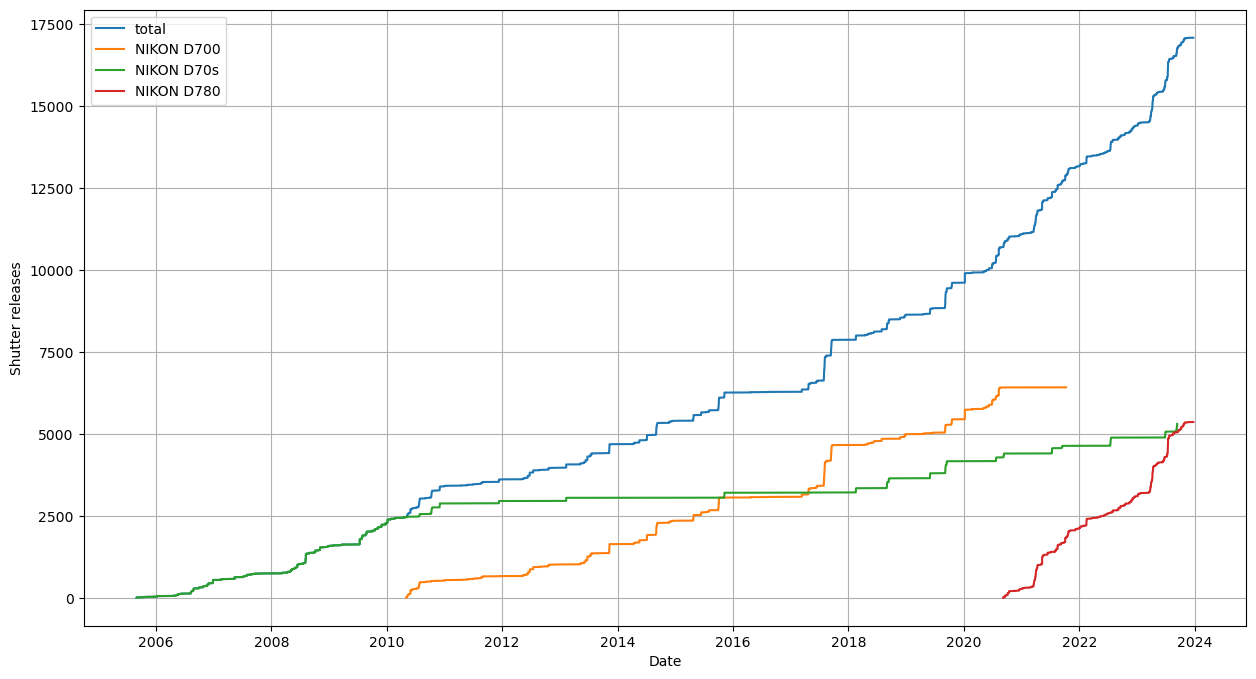

In [17]:
plot_successful_releases(photos, "model")

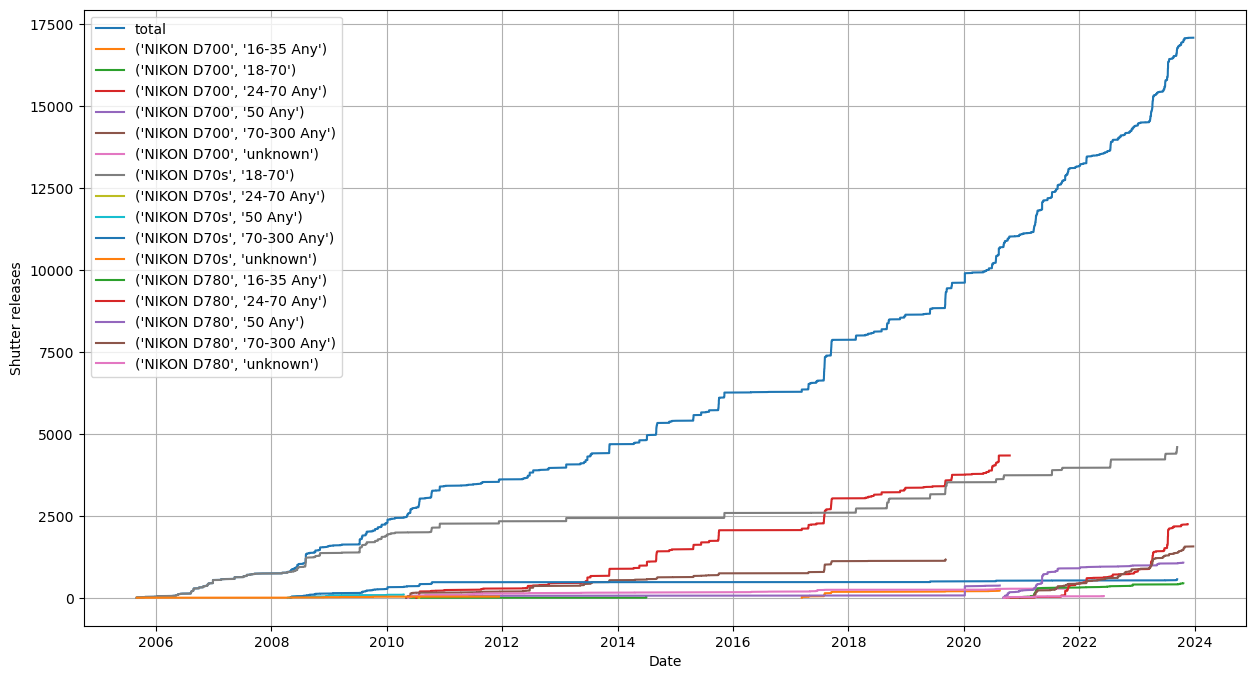

In [18]:
plot_successful_releases(photos, ["model", "lens_mapped"])

### Success rate

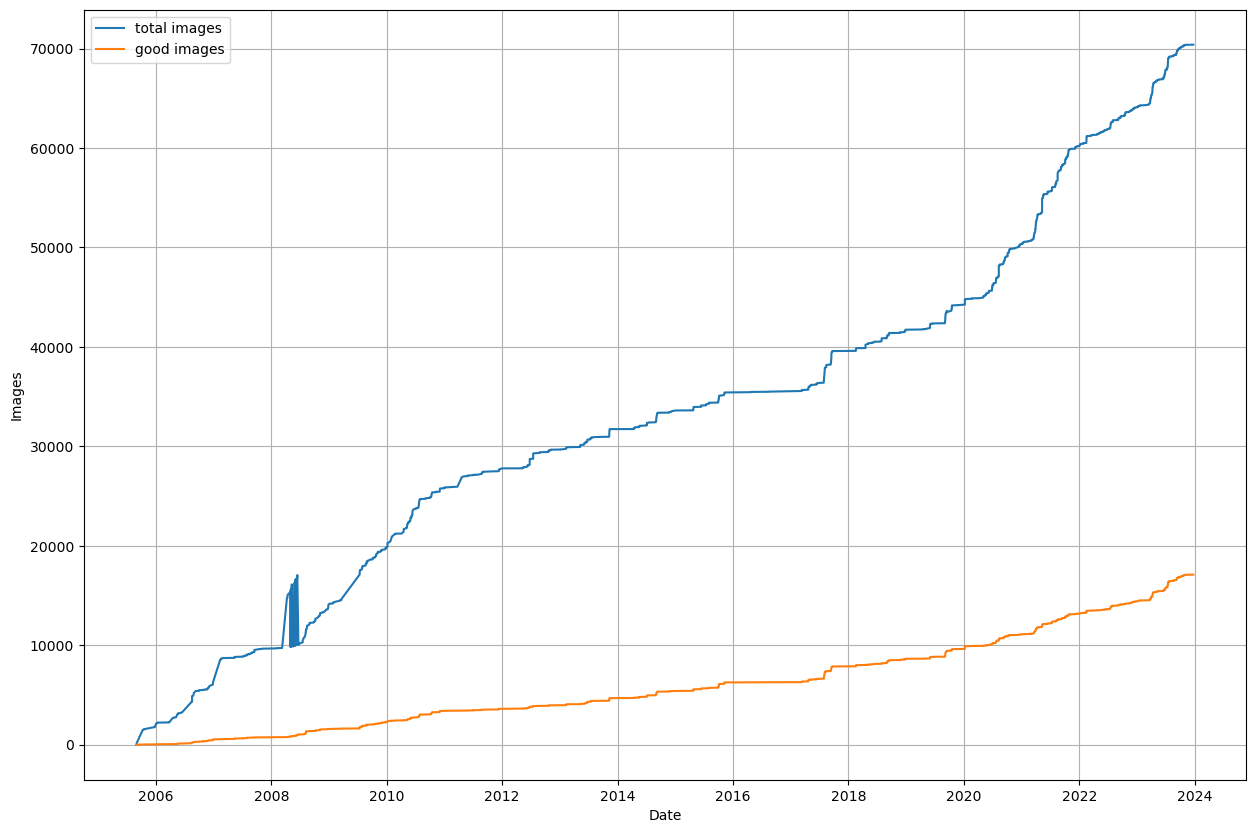

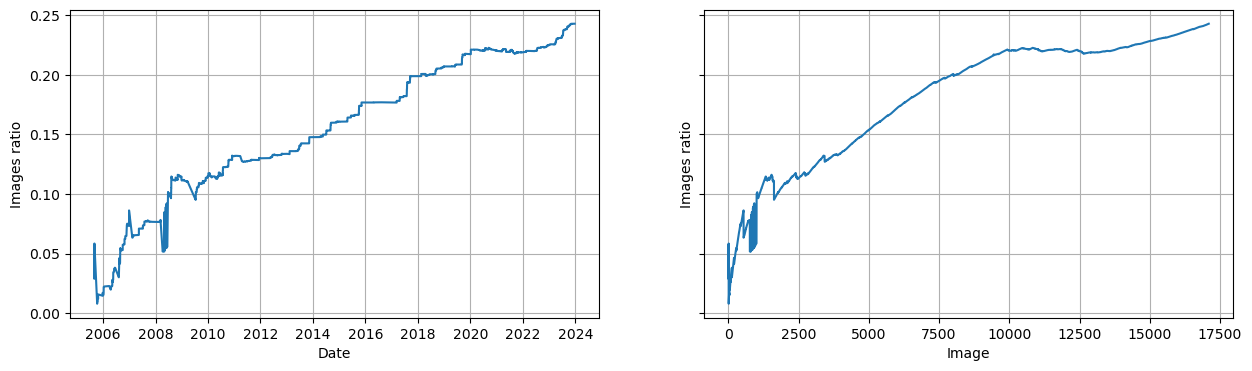

In [19]:
df = photos.reset_index(drop=True).reset_index().rename(columns={"index": "image_number"}).copy()
df["releases_to_image"] = df["image_number"] / df["total_releases"]
plt.figure(figsize=(15,10))
plt.plot(df['created'], df['total_releases'], label='total images')
plt.plot(df['created'], df['image_number'], label='good images')
plt.xlabel('Date')
plt.ylabel('Images')
plt.legend()
plt.grid()
plt.show()
fig, ax = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
ax[0].plot(df['created'], df['releases_to_image'])
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Images ratio')
ax[0].grid()
ax[1].plot(df['image_number'], df['releases_to_image'])
ax[1].set_xlabel('Image')
ax[1].set_ylabel('Images ratio')
ax[1].grid()
plt.show()

NIKON D700


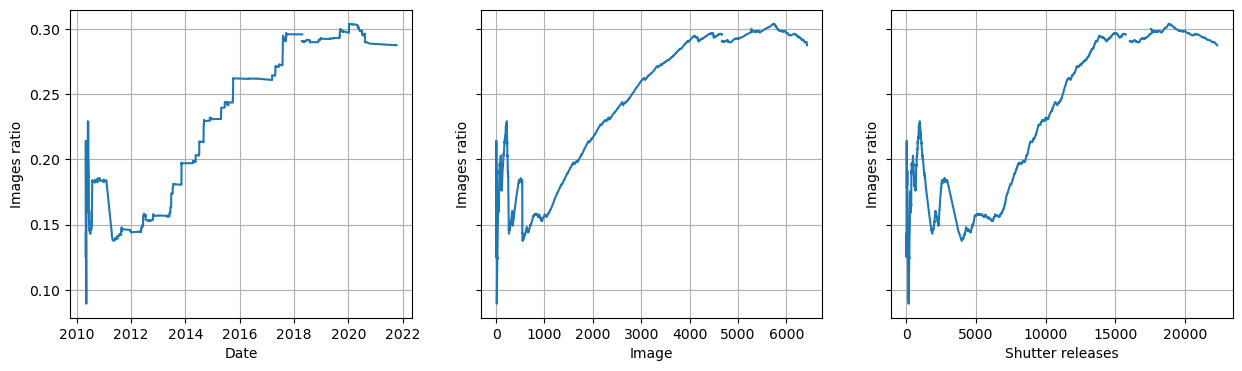

NIKON D70s


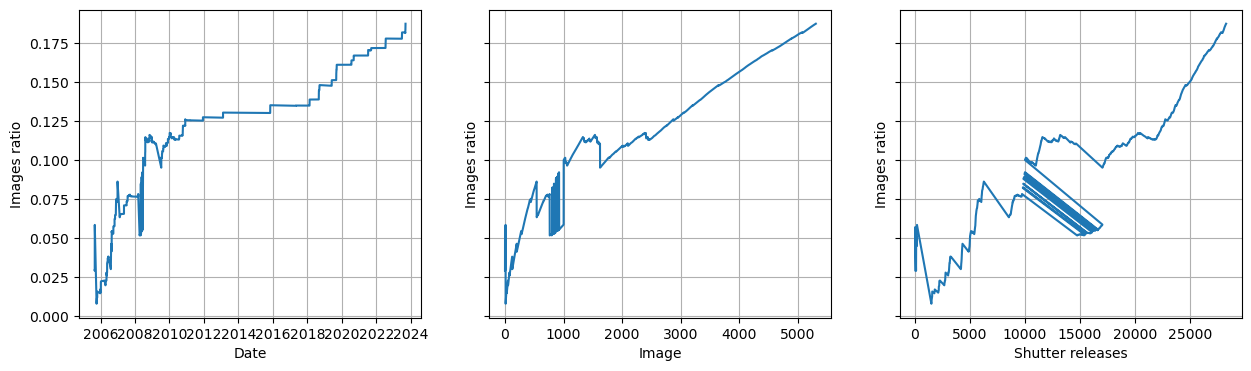

NIKON D780


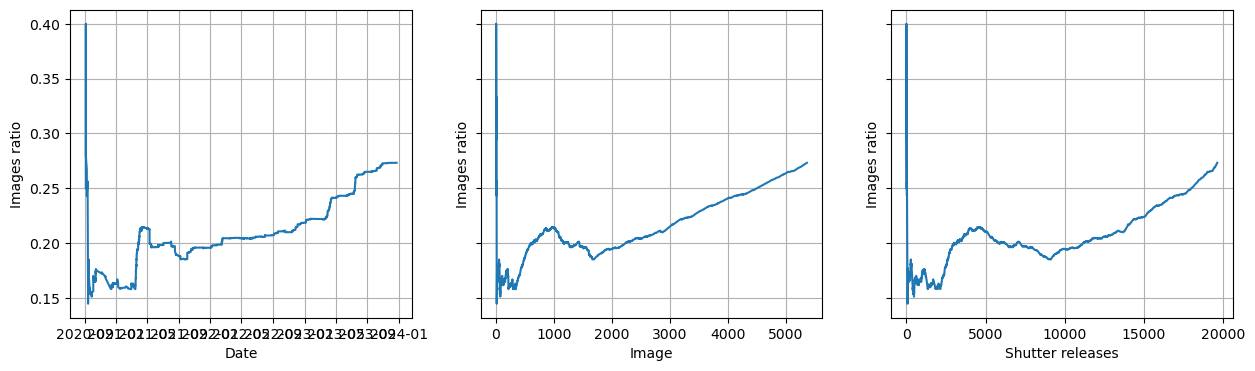

In [20]:
grouped = photos[['model', 'created', 'shutter_count']].groupby('model')
for camera, group in grouped:
    group["shutter_count"] -= group["shutter_count"].min()
    group = group.reset_index(drop=True).reset_index().rename(columns={"index": "image_number"})
    group["releases_to_image"] = group["image_number"] / group["shutter_count"]
    
    print(camera)
    fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    ax[0].plot(group['created'], group['releases_to_image'])
    ax[0].set_xlabel('Date')
    ax[0].set_ylabel('Images ratio')
    ax[0].grid()
    ax[1].plot(group['image_number'], group['releases_to_image'])
    ax[1].set_xlabel('Image')
    ax[1].set_ylabel('Images ratio')
    ax[1].grid()
    ax[2].plot(group['shutter_count'], group['releases_to_image'])
    ax[2].set_xlabel('Shutter releases')
    ax[2].set_ylabel('Images ratio')
    ax[2].grid()
    plt.show()

### Photos by camera

<Axes: >

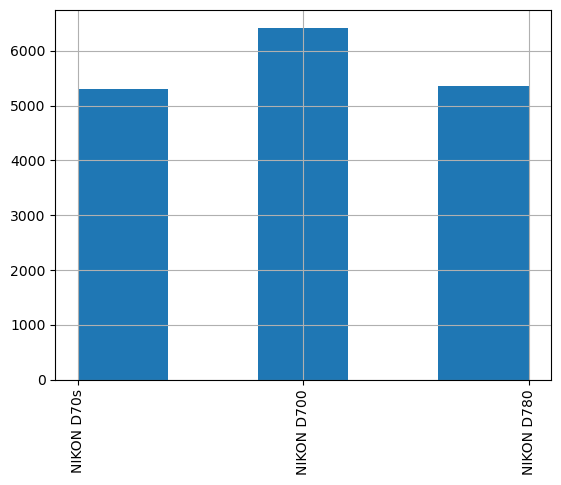

In [21]:
photos['model'].hist(xrot=90, bins=5)

## Lens stats

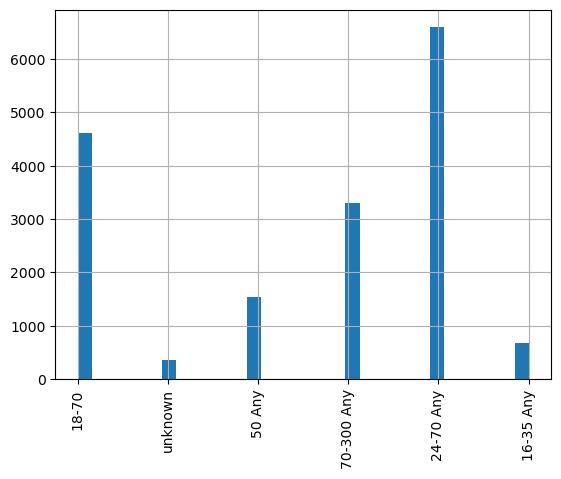

NIKON D70s


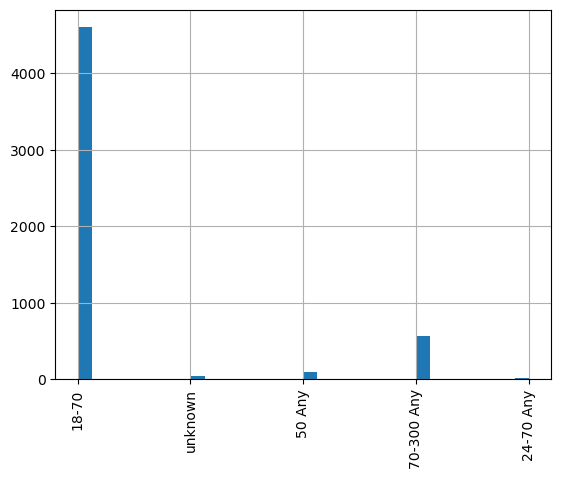

NIKON D700


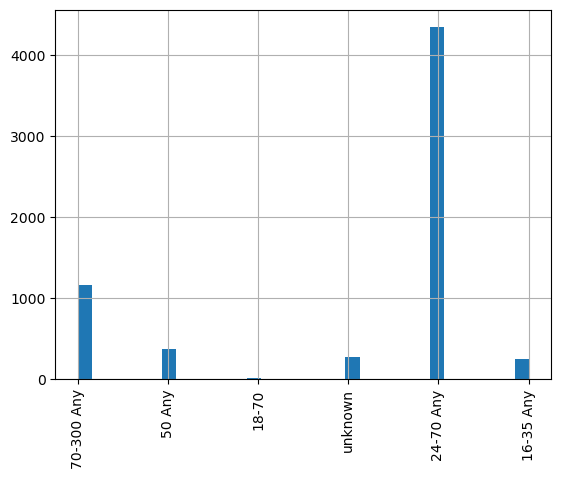

NIKON D780


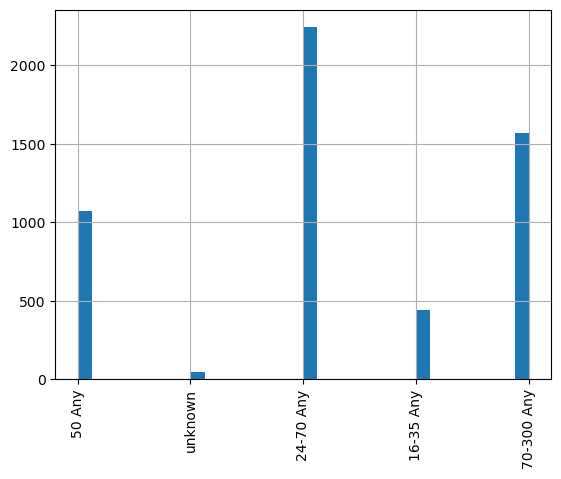

In [22]:
photos['lens_mapped'].hist(xrot=90, bins=2 * len(photos['lens'].unique()))
plt.show()
for camera in cameras:
    print(camera)
    photos[photos["model"] == camera]['lens_mapped'].hist(xrot=90, bins=2 * len(photos['lens'].unique()))
    plt.show()

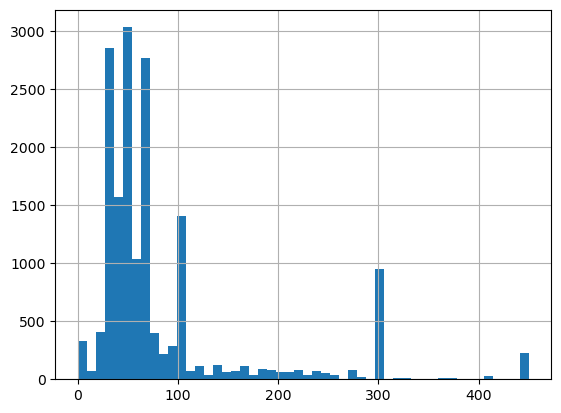

NIKON D70s


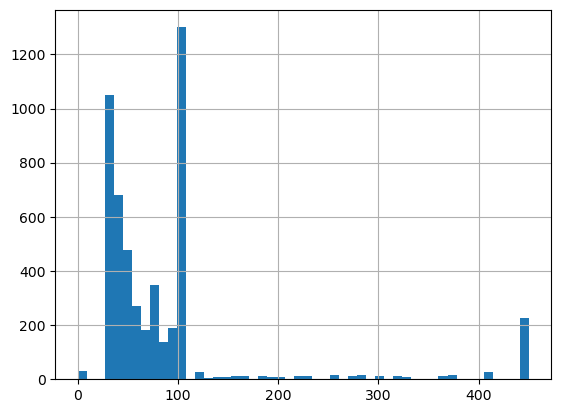

NIKON D700


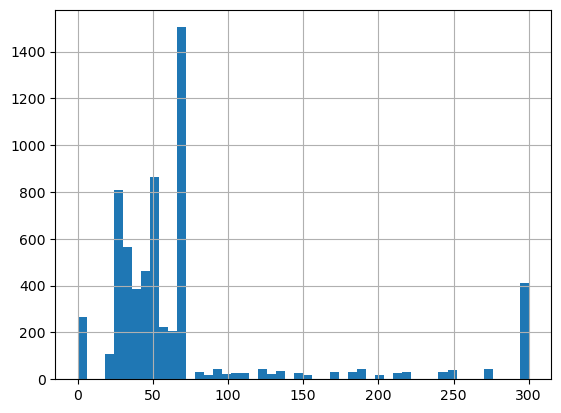

NIKON D780


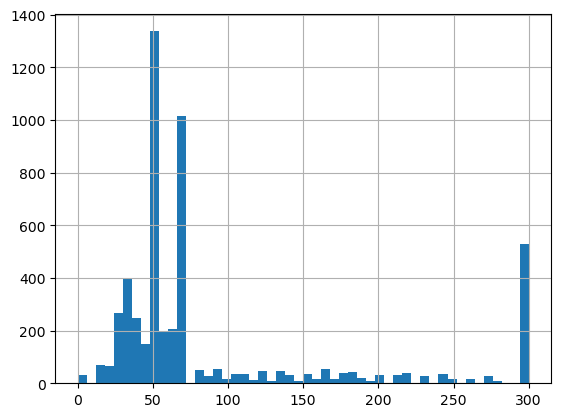

In [23]:
photos['focallength_35mm'].hist(bins=50)
plt.show()
for camera in cameras:
    print(camera)
    photos[photos["model"] == camera]["focallength_35mm"].hist(bins=50)
    plt.show()

<Axes: >

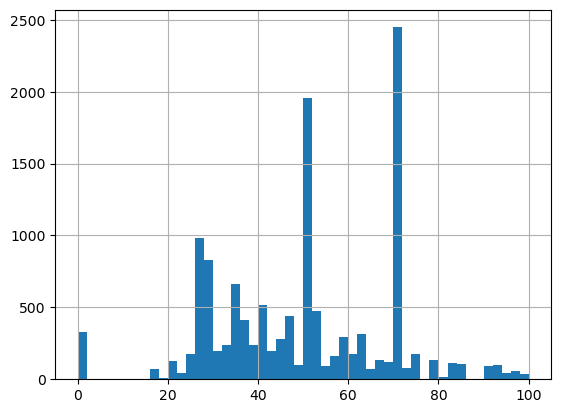

In [24]:
photos[photos['focallength_35mm'] <= 100]['focallength_35mm'].hist(bins=50)

## Light

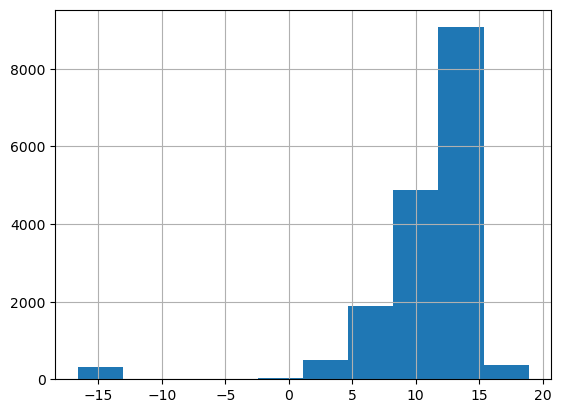

NIKON D70s


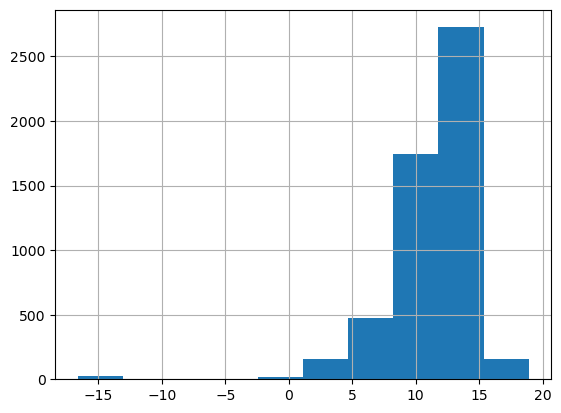

NIKON D700


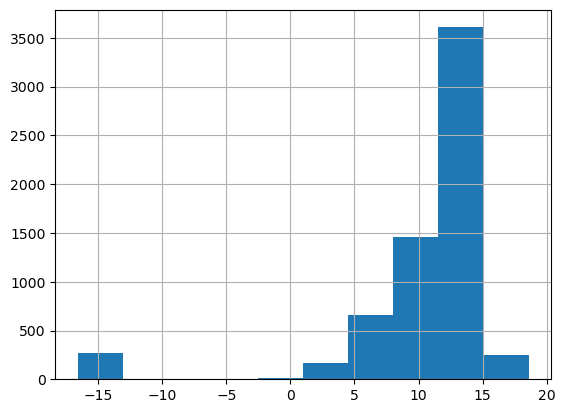

NIKON D780


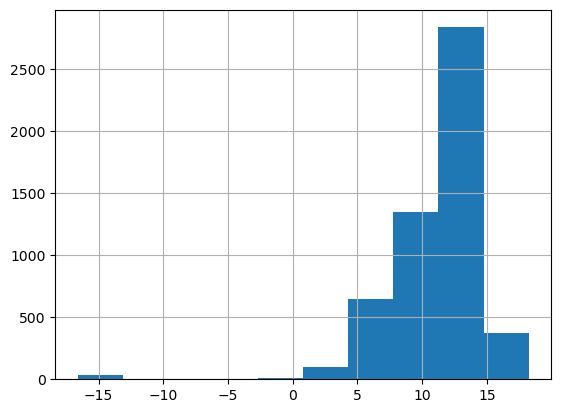

In [25]:
photos["ev"].hist()
plt.show()
for camera in cameras:
    print(camera)
    photos[photos["model"] == camera]["ev"].hist()
    plt.show()

## AF

<Axes: >

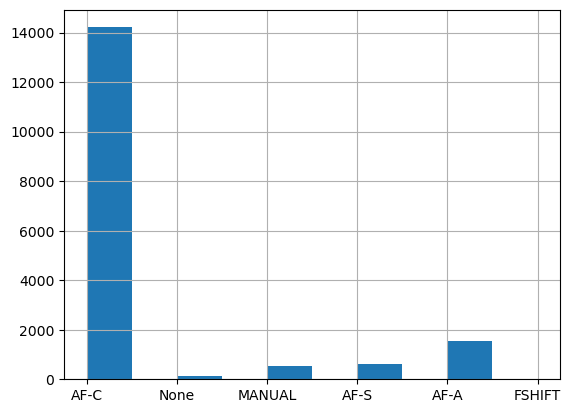

In [26]:
photos['af'].hist()

## ISO

<Axes: >

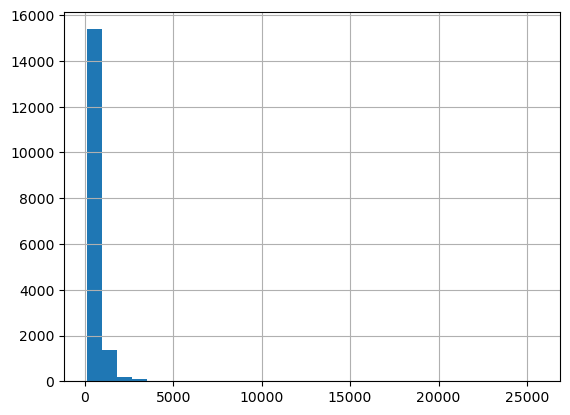

In [27]:
photos['iso'].hist(bins=30)

<Axes: >

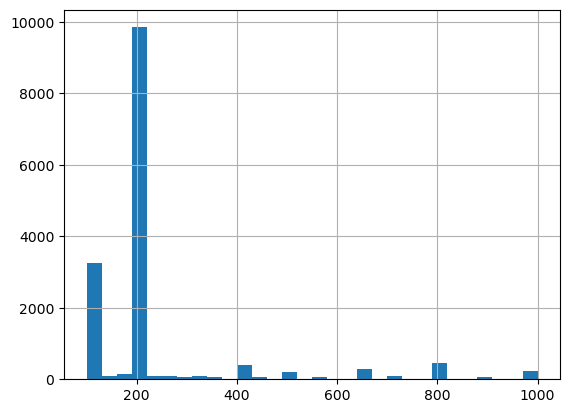

In [28]:
photos[photos['iso'] <= 1000]['iso'].hist(bins=30)

## Exposure

<Axes: >

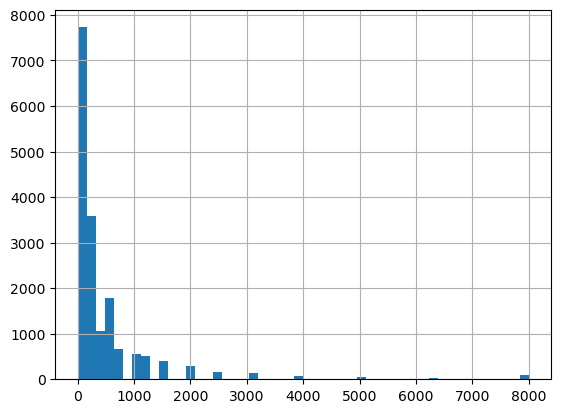

In [29]:
photos['exposure'].hist(bins=50)

<Axes: >

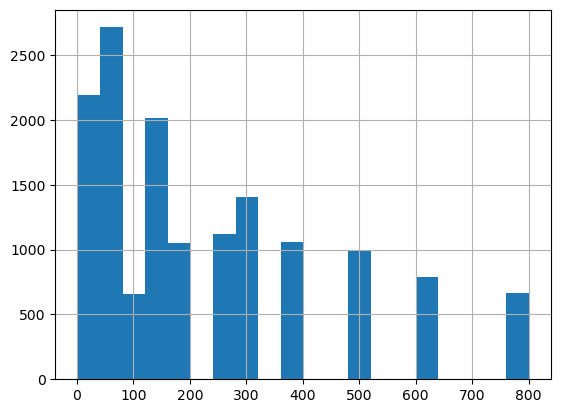

In [30]:
photos[(photos['exposure'] > 1) & (photos['exposure'] < 1000)]['exposure'].hist(bins=20)

## F/ number

<Axes: >

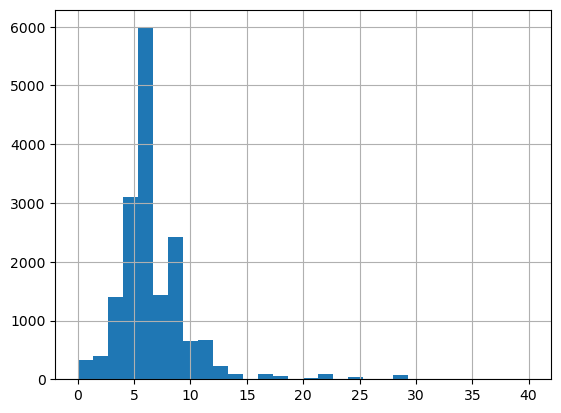

In [31]:
photos['fnumber'].hist(bins=30)

<Axes: >

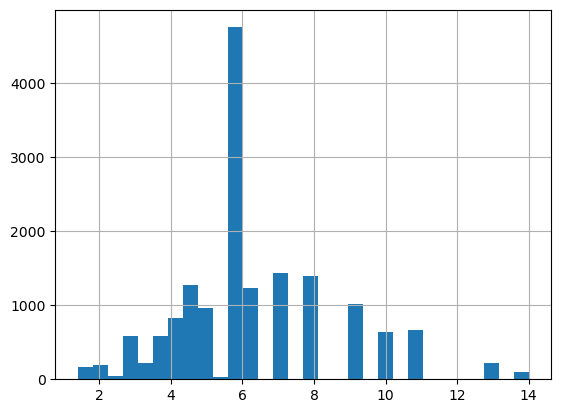

In [32]:
photos[(photos['fnumber'] > 0) & (photos['fnumber'] < 16)]['fnumber'].hist(bins=30)

## Exposure compensation

<Axes: >

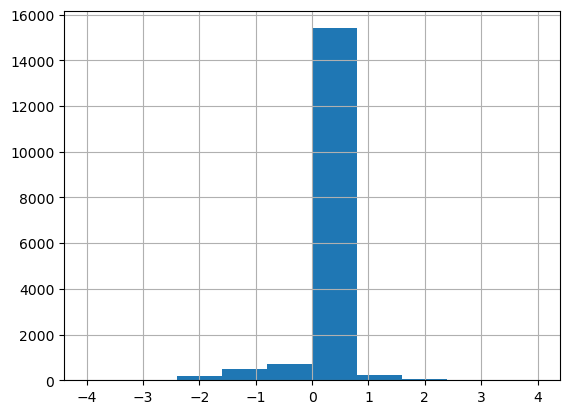

In [33]:
photos['exp_compensation'].hist()

## Flash

<Axes: >

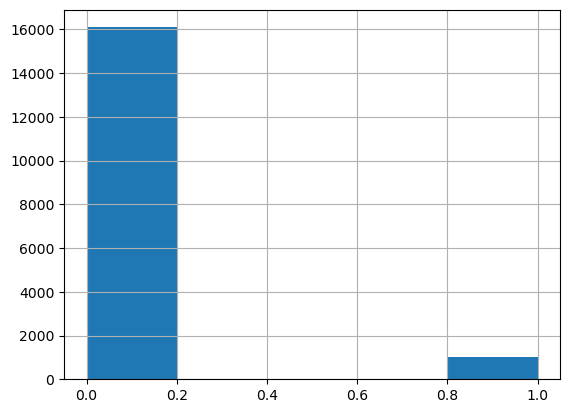

In [34]:
photos['flash'].map(lambda x: 0 if x == 0 else 1).hist(bins=5)